In [1]:
import os

os.chdir(os.path.join(os.getcwd(),'..'))
os.getcwd()

'/media/user/T7 Touch/Stage_Lucas/segmentation'

In [2]:
from src.nets import UNet
from src.downloads import download_data, unzip_data
from src.datasets2 import WarwickQU_Segmentation_Dataset
from src.training import train_UNet, EarlyStopping
from src.segmentation import post_processing
from src.visualization import plot_mini_batch

import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
import albumentations as alb

#### Datasets and Dataloaders options

In [3]:
batch_size = 4

Train = WarwickQU_Segmentation_Dataset(size=(128,128), channels=3, normalize=False, transforms=None, type='train')
Cell_train, Cell_val = random_split(Train, [0.8, 0.2])

train_loader = DataLoader(Cell_train, batch_size, shuffle=True)
val_loader = DataLoader(Cell_val, batch_size, shuffle=True)

Test = WarwickQU_Segmentation_Dataset(size=(128,128), channels=3, normalize=False, transforms=None, type='test')  # test mode

test_loader = DataLoader(Test, batch_size, shuffle=False)

#### Model's parameters

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = UNet(3, 64, 2)
EPOCHS = 100
STORE = 1
OPTIM = torch.optim.SGD(model.parameters(),
                                 lr=0.005, momentum=0.95,
                                 weight_decay=1e-4)

STOPPER = EarlyStopping(10)

SCHEDUL = torch.optim.lr_scheduler.OneCycleLR(OPTIM, 
                                                max_lr = 1e-1,
                                                steps_per_epoch=len(train_loader),
                                                epochs=EPOCHS, pct_start=0.43, div_factor=10, final_div_factor=1000,
                                                three_phase=True)

cuda


#### Training and loss plots

In [5]:
train_loss, val_loss, train_acc, val_acc, dices, ious = train_UNet(model, device, OPTIM, train_loader, val_loader, None, None, EPOCHS)

/home/user/stage-lucas/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 1/100, Train loss: 0.2291, Val loss: 0.0722, Train acc: 0.9022, Val acc: 1.0000, Dice: 0.0, IoU: 0.0
Epoch: 2/100, Train loss: 0.0015, Val loss: 0.0011, Train acc: 1.0000, Val acc: 1.0000, Dice: 0.0, IoU: 0.0
Epoch: 3/100, Train loss: 0.0002, Val loss: 0.0002, Train acc: 1.0000, Val acc: 1.0000, Dice: 0.0, IoU: 0.0
Epoch: 4/100, Train loss: 0.0001, Val loss: 0.0001, Train acc: 1.0000, Val acc: 1.0000, Dice: 0.0, IoU: 0.0
Epoch: 5/100, Train loss: 0.0000, Val loss: 0.0001, Train acc: 1.0000, Val acc: 1.0000, Dice: 0.0, IoU: 0.0
Epoch: 6/100, Train loss: 0.0000, Val loss: 0.0001, Train acc: 1.0000, Val acc: 1.0000, Dice: 0.0, IoU: 0.0
Epoch: 7/100, Train loss: 0.0000, Val loss: 0.0001, Train acc: 1.0000, Val acc: 1.0000, Dice: 0.0, IoU: 0.0


KeyboardInterrupt: 

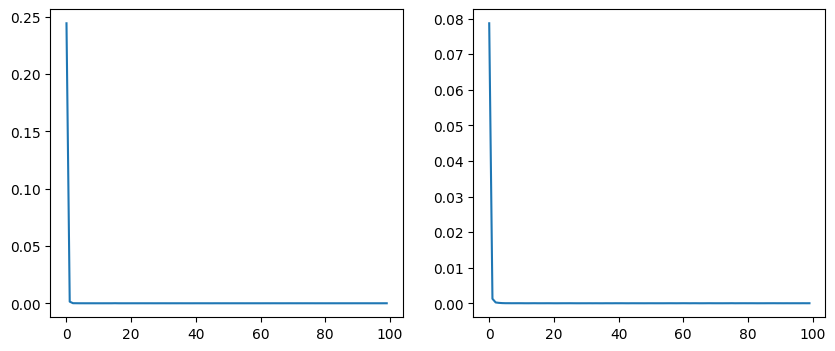

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(train_loss)
ax2.plot(val_loss)

In [7]:
torch.save(model.state_dict(), f'{os.getcwd()}/src/models/unet_warwick_005.pth')
# model_trained = UNet(1, 64, 2)
# model_trained.load_state_dict(torch.load(f'{os.getcwd()}/src/models/unet_model.pth'))
# model = model_trained

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)

#### Test predictions

In [16]:
final_imgs = torch.zeros((len(Test),3,512,768))
final_pred = torch.zeros((len(Test), 512,768))
model = model.to(device)
model.eval()
for i,imgs_test in enumerate(test_loader):
    imgs_test = imgs_test.to(device, dtype=torch.float32)

    with torch.no_grad():
        scores = model(imgs_test)
        preds = torch.argmax(scores, dim=1).float()

    for j in range(len(preds)):
        final_imgs[i*batch_size+j,:,:,:] = imgs_test[j]
        final_pred[i*batch_size+j] = preds[j]

final_imgs = final_imgs.cpu()
final_pred = final_pred.cpu()

In [17]:
last = post_processing(final_pred, binary=False)

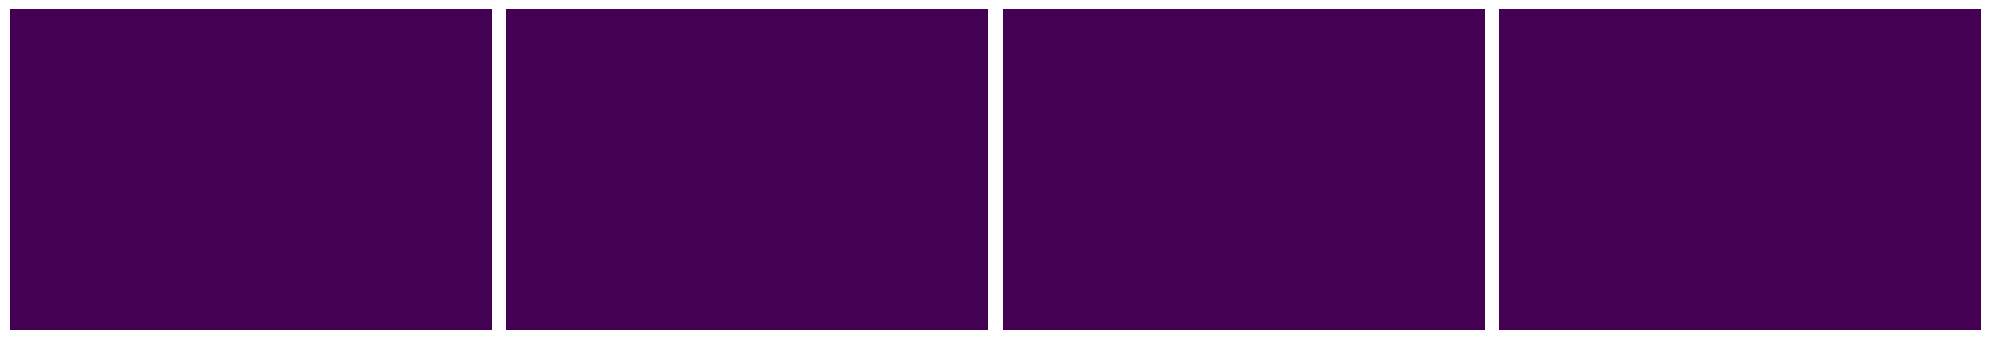

In [18]:
plot_mini_batch(final_pred[:4])

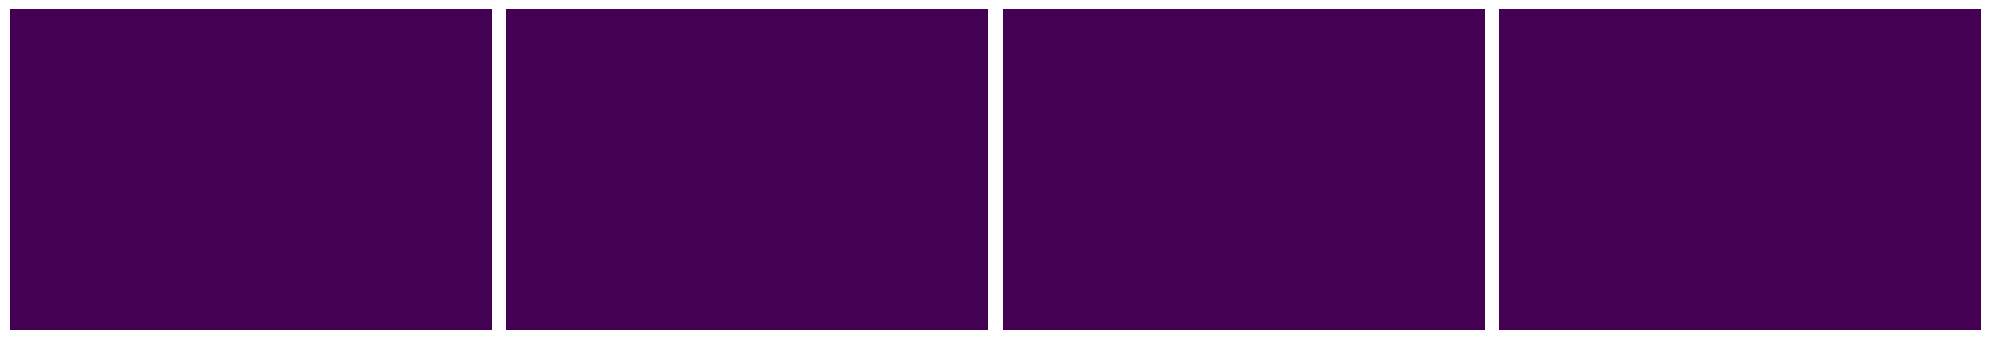

In [19]:
plot_mini_batch(last[:4])

In [ ]:
plot_mini_batch(final_imgs[:4])